# Error Analysis in Classification: Identifying Misclassified Cases

## Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

from sklearn.metrics import confusion_matrix

pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:,.3f}'.format)

%load_ext autoreload
%autoreload all
from process_bank_deposit import get_train_test_data

## Load the test data

In [ ]:
raw_data = pd.read_csv('./data/bank_data.csv')
data_dict = get_train_test_data(raw_data, 'y')

train_inputs, train_targets = data_dict['train_inputs'], data_dict['train_targets']
test_inputs, test_targets = data_dict['test_inputs'], data_dict['test_targets']

In [ ]:
model = joblib.load('./data/model_lgb.joblib')

In [ ]:
model_pipeline = model['model_pipeline_lgb']
model_pipeline.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('onehot_enc',
                                                  Pipeline(steps=[('onehot_enc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome', 'previous']),
                                                 ('ord_enc',
                                                  OrdinalEncoder...
                 LGBMClassifier(colsample_bytree=0.6796274949129392,
                                learning_rate=0.0030998891517021107,
                                max_depth=5, metric='auc', min_child_weight=7,
                                min_split_gain=0.09286221963181833,
                                n_estimators=450, n_jobs=-1, num_leaves=20,
                                objective='binary', random_state=42,
                                reg_alpha=0.5314865350224595,
                                reg_lambda=0.7606527336556136,
                                scale_pos_weight=7.876,
                                subsample=0.7857452506248942, subsample_freq=1,
                                verbose=-1))])

In [ ]:
test_with_pred = pd.concat([test_inputs, test_targets], axis=1)

In [ ]:
test_pred = model_pipeline.predict(test_inputs)
test_pred_proba = model_pipeline.predict_proba(test_inputs)

test_with_pred['predict'] = test_pred
test_with_pred[['prob_class_0', 'prob_class_1']] = test_pred_proba

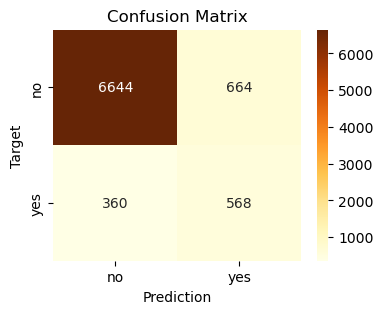

In [ ]:
cm = confusion_matrix(test_with_pred['y'], test_with_pred['predict'])
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap='YlOrBr',
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'],
            fmt='.0f')
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Confusion Matrix')
plt.show()

- True positive (TP): 568 items (correctly predicted "yes")
- False negative (FN): 360 (incorrectly predicted "no" when actually "yes")
- False positive (FP): 664 (incorrectly predicted "yes" when actually "no")
- True negative (TN): 6644 (correctly predicted "no")

In [ ]:
test_with_pred['misclassified'] = (test_with_pred.y != test_with_pred.predict).astype(int)

In [ ]:
test_with_pred.loc[test_with_pred['misclassified'] == 1, 'y'].value_counts(normalize=True)

y
0   0.648
1   0.352
Name: proportion, dtype: float64

- Across all misclassified examples class "no" misclassified more often than class "yes".
- A significant proportion of positive cases are misclassified as negative. The model struggles more with identifying the positive class (label "yes").
- The false negative rate is high (38.8%), meaning the model frequently fails to detect actual positives.
- The model is biased towards predicting class 0 (the majority class).
- The high FN rate is concerning because of detecting class 1 is important.
- The low FP rate suggests the model is conservative about predicting class 1 due to class imbalance.

### Feature Analysis of Misclassified Samples

In [ ]:
numerical_cols = test_with_pred.select_dtypes('number').columns.to_list()

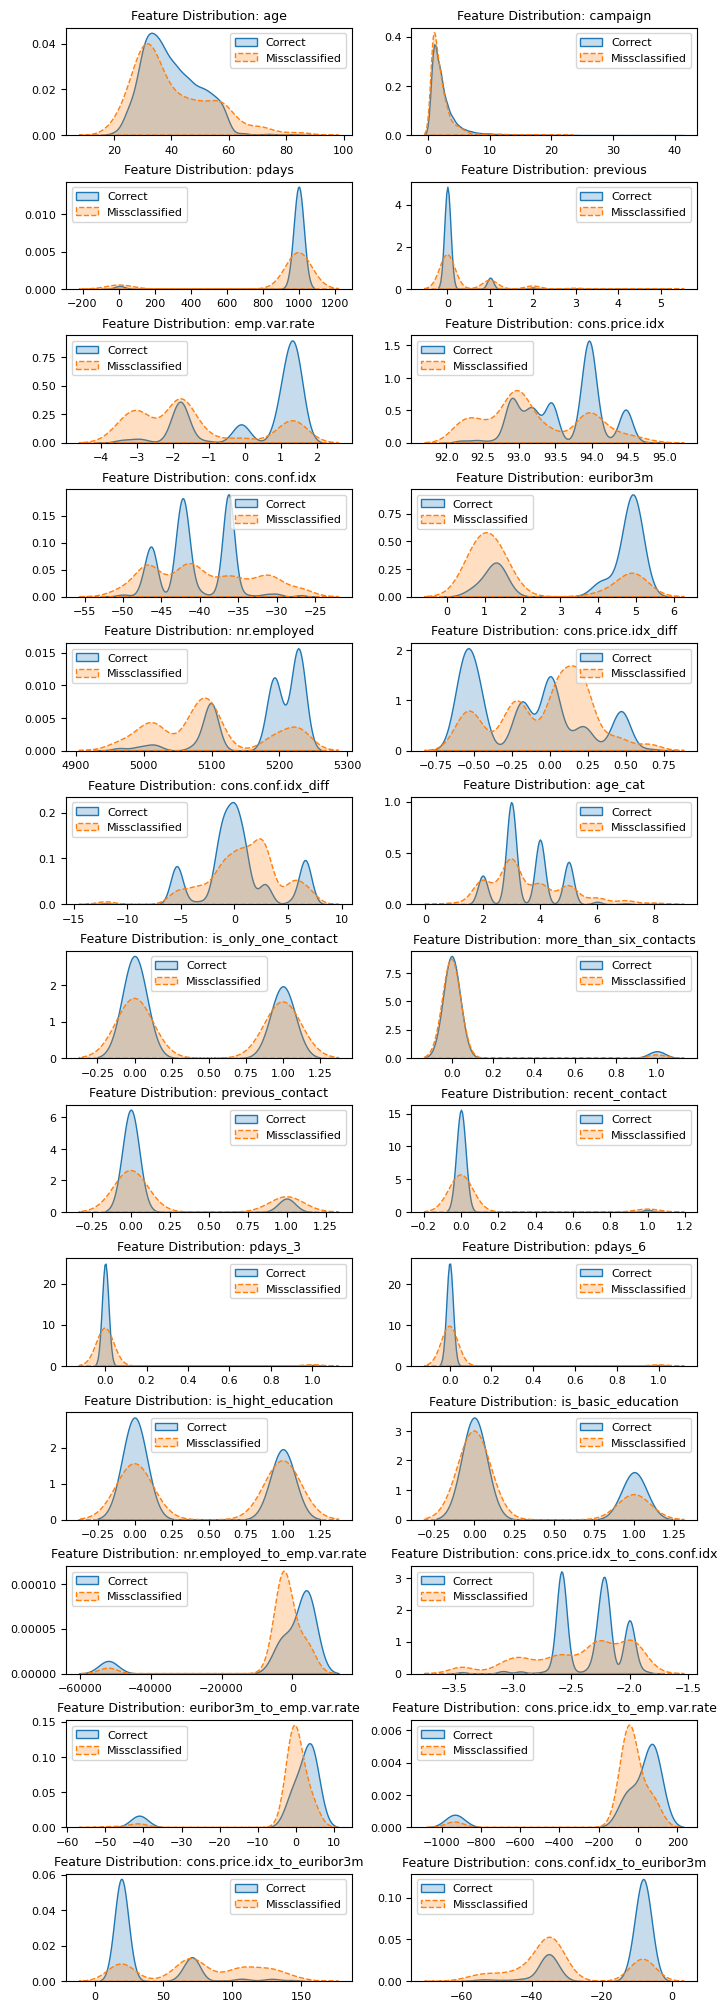

In [ ]:
fig, axs = plt.subplots(13, 2, figsize=(7, 20), layout='constrained')
for ax, col in zip(axs.flat, numerical_cols[:-5]):
    sns.kdeplot(test_with_pred.loc[test_with_pred['misclassified'] == 0, col],
                label='Correct', fill=True, ax=ax)
    sns.kdeplot(test_with_pred.loc[test_with_pred['misclassified'] == 1, col],
                label='Missclassified',
                fill=True, linestyle='dashed', ax=ax)
    ax.set_title(f"Feature Distribution: {col}", fontsize=9)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.legend(fontsize=8)

plt.show()

- Some features have very different distributions in misclassified cases, so our model may struggle to generalize in those areas.
- Highly important macroeconomic features such `euribor3m`, `nr.employed`, `cons.conf.idx_to_euribor3m`, `cons.price.idx_to_euribor3m` and so on are significantly different, the model might need better feature engineering or additional data.

### Model Confidence

In [ ]:
misclassified_confidence = test_with_pred.loc[
    test_with_pred['misclassified'] == 1, ['prob_class_0', 'prob_class_1']
    ].max(axis=1)

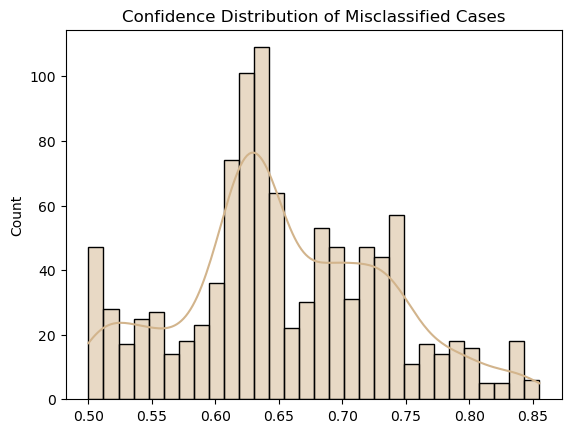

In [24]:
sns.histplot(misclassified_confidence, bins=30, kde=True, color='tan')
plt.title("Confidence Distribution of Misclassified Cases")
plt.show()

It looks like misclassified cases tend to have confidence scores mostly between 0.6 and 0.65, with fewer cases after 0.75. This suggests that:
- Most misclassifications occur in uncertain predictions. The model isn't fully confident when making incorrect predictions, which is expected.
- Fewer misclassifications at high confidence levels. When the model assigns a high probability (e.g., > 0.75), it's usually correct.
- If a lot of misclassifications are near 0.6-0.65, adjusting the decision threshold might help balance precision and recall.

### SHAP Analysis on Misclassified Cases

In [41]:
explainer = shap.TreeExplainer(model_pipeline[-1])

In [46]:
input_cols = test_inputs.columns.to_list()

In [ ]:
test_inputs_missclass_transform = model_pipeline[0].transform(
    test_with_pred.loc[test_with_pred['misclassified'] == 1, input_cols])

In [ ]:
explainer = shap.TreeExplainer(model_pipeline[-1])
shap_values = explainer(test_inputs_missclass_transform)

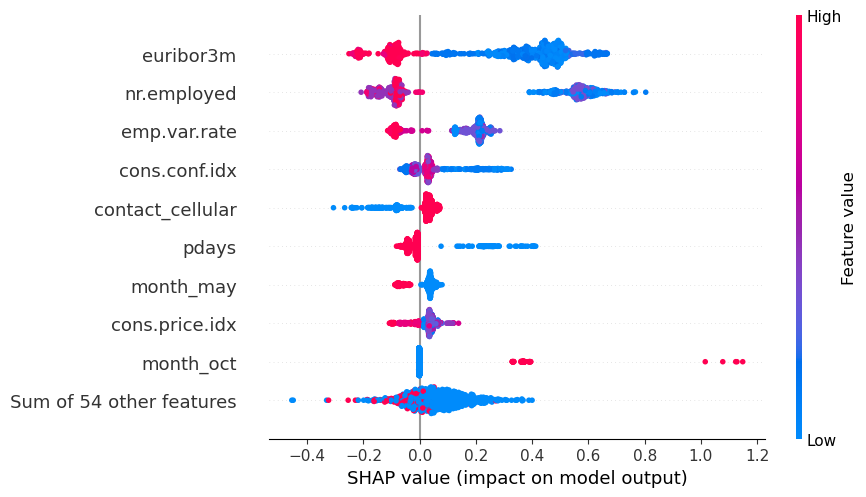

In [51]:
shap.plots.beeswarm(shap_values)

The model appears to focus more on macroeconomic features while neglecting personal client characteristics.

### Possible Future Actions:

- Identify which features contribute to misclassifications and refine feature selection or model parameters.
- Improve feature engineering to enhance class 1 ("yes") separation.
- Optimize the decision threshold based on the precision-recall trade-off.